In [1]:
from manim import *

config.media_width = "100%"
_RV = "-v WARNING -qm --progress_bar None --disable_caching Example"
_RI = "-v WARNING -s --progress_bar None --disable_caching Example"

Manim Community v0.17.2

## Creación de la clase `DipoloElectrico2D`

In [2]:
class DipoloElectrico2D_v0(VMobject):

    def __init__(self, angle):
        super().__init__()
        self.angle = angle
        self.create()
        
    def create(self):
        
        linea = Line(LEFT * 0.8, RIGHT * 0.8, stroke_width=7)
        linea.rotate(self.angle)
        
        #polo_positivo = Circle(radius=self.radius, color=RED).move_to(linea.get_end())
        #polo_negativo = Circle(radius=self.radius, color=BLUE).move_to(linea.get_start())
        
        polo_positivo = Dot(color=RED).scale(3).move_to(linea.get_end())
        polo_negativo = Dot(color=BLUE).scale(3).move_to(linea.get_start())
        
        linea.add(polo_positivo, polo_negativo)
        
        self.add(linea)


In [3]:
TIME = 30

class Example(Scene):

    def construct(self):
        
        print("Frame rate:", self.camera.frame_rate)

        dipolo = DipoloElectrico2D_v0(PI/8)
        dipolo.save_state()
        dipolo._count = 0
        
        def dipolo_dinamica(mob, dt):
            mob.restore()
            mob.angle += dt
            mob.rotate(mob.angle)
            dipolo._count += 1
            #print("dt=", dt)
            
        dipolo.add_updater(dipolo_dinamica)
        self.add(dipolo)
        self.wait(TIME)
        
        print("count:", dipolo._count)
        

%manim $_RV

Frame rate: 30
count: 902


In [4]:
class Example(Scene):

    def construct(self):

        dipolo1 = DipoloElectrico2D_v0(PI/8).shift(LEFT * 2)
        dipolo1.save_state()
        
        dipolo2 = DipoloElectrico2D_v0(PI/3).shift(RIGHT * 2)
        dipolo2.save_state()
        
        def dipolo_dinamica(mob, dt):
            mob.restore()
            mob.angle += dt
            mob.rotate(mob.angle)

        dipolo1.add_updater(dipolo_dinamica)
        dipolo2.add_updater(dipolo_dinamica)
        self.add(dipolo1, dipolo2)
        self.wait(TIME)
        

%manim $_RV

El diámetro de los virus va de $20 \, nm$ a $500 \, nm$ $\left[20\times 10^{-9}, 500\times 10^{-9}\right]$.

El diámetro del coronavirus va de $40 \, nm$ a $140 \, nm$. $\left[40\times 10^{-9}, 140\times 10^{-9}\right]$.

https://www.news-medical.net/health/The-Size-of-SARS-CoV-2-Compared-to-Other-Things.aspx

In [5]:
from scipy import integrate

In [6]:
class DipoloElectrico2D(VMobject):
    

    def __init__(self, angle, 
                 t_start=0, t_end=30, ele=140e-9, q=1.6e-19, m=1e-7, E=np.array([500e3, 0, 0]), 
                 longitud_escala=[40e-9, 140e-9], fps=30):
        
        super().__init__()
        
        self.angle = angle
        self.t_start = t_start
        self.t_end = t_end
        self.ele = ele
        self.q1 = q
        self.q2 = -q
        self.m = m
        self.E = E
        self.longitud_escala = longitud_escala
        self.fps = int(fps)
        
        self.create()
        self.calculate_dynamics()
        
    def create(self):
        
        longiud2 = self.escalar([self.ele], self.longitud_escala, [0.15, 0.8])[0]
        stroke_w = self.escalar([self.ele], self.longitud_escala, [4, 9])[0]
        scaledot = self.escalar([self.ele], self.longitud_escala, [1, 3])[0]
        
        linea = Line(LEFT * longiud2, RIGHT * longiud2, stroke_width=stroke_w) # 0.15 - 0.8, 4 - 9
        
        polo_positivo = Dot(color=RED).scale(scaledot).move_to(linea.get_end())    # 1 - 3
        polo_negativo = Dot(color=BLUE).scale(scaledot).move_to(linea.get_start()) # 1 - 3
        
        linea.add(polo_positivo, polo_negativo)
        
        self.add(linea)

    def calculate_dynamics(self):
        
        theta = np.array([self.angle, 0, 0])
        omega = np.array([0, 0, 0])
        
        r1 = np.array([(self.ele/2)*np.cos(theta[0]), (self.ele/2)*np.sin(theta[0]), 0])    # carga positva
        r2 = np.array([-(self.ele/2)*np.cos(theta[0]), -(self.ele/2)*np.sin(theta[0]), 0])  # carga negativa
        
        l = r2 - r1
        p = l * self.q1
        
        I = self.momento_inercia_barra(self.m, l)
        
        self.solution = integrate.solve_ivp(self.angulo_dipolo, 
                                            [self.t_start, self.t_end], 
                                            [theta[0], theta[1], theta[2], omega[0], omega[1], omega[2]],
                                            method='RK45', 
                                            t_eval=np.linspace(self.t_start, self.t_end, self.t_end * self.fps + 2),
                                            args=(I, p, self.E)
                                           )
        
    def angulo_dipolo(self, t, theta, I, p, E):
    
        # componentes
        x, y, z = theta[0:3]
        # velocidades (angulares)
        vx, vy, vz = theta[3:6]

        # calcular aceleraciones
        ax = p[0] * E[0] * np.sin(x) / I[0] if I[0] != 0 else 0
        ay = p[1] * E[1] * np.sin(y) / I[1] if I[1] != 0 else 0
        az = p[2] * E[2] * np.sin(z) / I[2] if I[2] != 0 else 0

        return [vx, vy, vz, ax, ay, az]


    def momento_inercia_barra(self, n, l):

        return np.array([self.m * l[0]**2, self.m * l[1]**2, self.m * l[2]**2]) / 12
    
    
    def escalar(self, values, actual_bounds, desired_bounds):
        return [
            desired_bounds[0] + (x - actual_bounds[0]) * (desired_bounds[1] - desired_bounds[0])
            / (actual_bounds[1] - actual_bounds[0]) 
            for x in values
        ]

In [7]:
TOTAL_TIME = 30

            
class Example(Scene):

    def construct(self):
        
        print("self.camera.frame_rate =", self.camera.frame_rate)
        
        initial_angle = PI/4

        dipolo = DipoloElectrico2D(initial_angle, t_end=TOTAL_TIME, fps=self.camera.frame_rate, 
                                   E=np.array([500e3, 0, 0]), ele=140e-9)
                                   #E=np.array([500e2, 0, 0]), ele=40e-9)
        dipolo.save_state()
        dipolo._counter = 0
        
        def dipolo_dinamica(mob, dt):
            mob.restore()
            mob.rotate(mob.solution.y[0][mob._counter])
            mob._counter += 1
            
        dipolo.add_updater(dipolo_dinamica)
        self.add(dipolo)
        self.wait(TOTAL_TIME)
        
        print("count:", dipolo._counter)
        

%manim $_RV

self.camera.frame_rate = 30
count: 902


In [8]:
#manim -v WARNING -qm --progress_bar None --disable_caching --fps=60 Example

In [9]:
#manim -v WARNING -qm --progress_bar None --disable_caching --fps=15 Example

In [10]:
dipolo_30 = DipoloElectrico2D(PI/8, t_end=TOTAL_TIME, fps=30)

dipolo_60 = DipoloElectrico2D(PI/8, t_end=TOTAL_TIME, fps=60)

In [11]:
dipolo_30.solution.y[0][0:30]

array([ 0.39269908,  0.37705412,  0.33134284,  0.2590323 ,  0.16567809,
        0.05889955, -0.0526476 , -0.15992477, -0.25431722, -0.32805458,
       -0.37548921, -0.39270555, -0.37852247, -0.33435286, -0.26334717,
       -0.17079306, -0.0643137 ,  0.04725869,  0.15492831,  0.25005115,
        0.32493142,  0.37376843,  0.3926323 ,  0.37994882,  0.3370069 ,
        0.26720728,  0.17571107,  0.06971914, -0.04182729, -0.14993571])

In [12]:
dipolo_60.solution.y[0][0:60]

array([ 0.39269908,  0.3887649 ,  0.37703685,  0.3577463 ,  0.33127647,
        0.2981165 ,  0.25889244,  0.21436964,  0.16545269,  0.11318149,
        0.05859224,  0.00280786, -0.05301699, -0.10775817, -0.16032201,
       -0.20964534, -0.25469547, -0.29449184, -0.32836131, -0.35561624,
       -0.37567062, -0.38811449, -0.392714  , -0.38941133, -0.37832475,
       -0.35972318, -0.33393152, -0.30139427, -0.26270243, -0.21859351,
       -0.16995153, -0.11780699, -0.06333262, -0.00759068,  0.04830759,
        0.10319288,  0.15595469,  0.20554122,  0.25095943,  0.29127503,
        0.32562473,  0.35344134,  0.37416694,  0.38733694,  0.39266794,
        0.39005777,  0.37958546,  0.36151127,  0.33624417,  0.30423541,
        0.26607137,  0.22246705,  0.17426428,  0.12243162,  0.06806445,
        0.01237628, -0.04355832, -0.09860148, -0.15159845, -0.2014765 ])

In [13]:
a = np.linspace(0, 30, 30*30 + 2)   # start_time (0 sec), end_time (30 sec), quantity (30 sec * 30 fps)

len(a)

902

In [14]:
np.linspace(0, 10330, 10001)

array([0.0000000e+00, 1.0330000e+00, 2.0660000e+00, ..., 1.0327934e+04,
       1.0328967e+04, 1.0330000e+04])

In [15]:
def normalizes(values, actual_bounds, desired_bounds):
    return [
        desired_bounds[0] + (x - actual_bounds[0]) * (desired_bounds[1] - desired_bounds[0])
        / (actual_bounds[1] - actual_bounds[0]) 
        for x in values
    ]

In [16]:
normalizes(
    [0.92323, 0.7232322, 0.93832, 0.4344433],
    (0, 1),
    (0.25, 0.5)
)

[0.4808075, 0.43080805, 0.48458, 0.35861082499999997]

-------------------

### Validación de la animación: mover 90 grados durante 10 segundos y generar con diferentes valores de fps

In [17]:
class DipoloElectrico2DTest(VMobject):

    def __init__(self, angle):
        super().__init__()
        self.angle = angle
        self.create()
        
    def create(self):
        
        linea = Line(LEFT * 0.8, RIGHT * 0.8, stroke_width=7)
        linea.rotate(self.angle)
        
        polo_positivo = Dot(color=RED).scale(3).move_to(linea.get_end())
        polo_negativo = Dot(color=BLUE).scale(3).move_to(linea.get_start())
        
        linea.add(polo_positivo, polo_negativo)
        
        self.add(linea)


In [18]:
TIME = 10

class ExampleTest(Scene):

    def construct(self):
        
        print("Frame rate:", self.camera.frame_rate)

        dipolo = DipoloElectrico2DTest(0)
        dipolo.save_state()
        
        dAngle = (PI/2) / (self.camera.frame_rate * TIME)
        
        def dipolo_dinamica(mob, dt):
            #print("mob.angle=", mob.angle)
            mob.restore()
            mob.angle += dAngle
            mob.rotate(mob.angle)
            #print("dt=", dt)
            
        dipolo.add_updater(dipolo_dinamica)
        self.add(dipolo)
        self.wait(TIME)

In [19]:
manim -v WARNING -qm --progress_bar None --disable_caching --fps=15 ExampleTest

Frame rate: 15.0


In [20]:
manim -v WARNING -qm --progress_bar None --disable_caching --fps=30 ExampleTest

Frame rate: 30.0


In [21]:
manim -v WARNING -qm --progress_bar None --disable_caching --fps=60 ExampleTest

Frame rate: 60.0


In [22]:
manim -v WARNING -qm --progress_bar None --disable_caching --fps=90 ExampleTest

Frame rate: 90.0


In [23]:
manim -v WARNING -qm --progress_bar None --disable_caching --fps=120 ExampleTest

Frame rate: 120.0


---------------------

## Creación de la clase `Placas2D`

In [24]:
class Placas2D(VMobject):

    def __init__(self, ancho=0.5):
        super().__init__()
        self.ancho = ancho
        self.create()
        
    def create(self):
        
        placa_positiva = Rectangle(width=self.ancho, height=7.5, color=RED_B)\
                         .set_fill(RED_E, 1).move_to(LEFT * (7.0 - self.ancho))
        placa_negativa = Rectangle(width=self.ancho, height=7.5, color=BLUE)\
                         .set_fill(BLUE_E, 1).move_to(RIGHT * (7.0 - self.ancho))
        
        self.add(placa_positiva, placa_negativa)


In [25]:
TOTAL_TIME = 30

            
class Example(Scene):

    def construct(self):
        
        #print("self.camera.frame_rate =", self.camera.frame_rate)
        
        placas = Placas2D(ancho=0.4)
        
        initial_angle = PI/4

        dipolo = DipoloElectrico2D(initial_angle, t_end=TOTAL_TIME, fps=self.camera.frame_rate, 
                                   E=np.array([500e3, 0, 0]), ele=140e-9)
                                   #E=np.array([500e2, 0, 0]), ele=40e-9)
        dipolo.save_state()
        dipolo._counter = 0
        
        def dipolo_dinamica(mob, dt):
            mob.restore()
            mob.rotate(mob.solution.y[0][mob._counter])
            mob._counter += 1
            
        dipolo.add_updater(dipolo_dinamica)
        self.add(dipolo, placas)
        self.wait(TIME)
        
        #print("count:", dipolo._counter)
        

%manim $_RV

--------------------

## Creación de varios dipolos en ubicaciones random

In [26]:
from random import uniform

In [27]:
TOTAL_TIME = 30

            
class Example(Scene):

    def construct(self):
        
        ANCHO_PLACAS = 0.2
        OFFSET_COORD_X = 0.5
        OFFSET_COORD_Y = 0.4
        CANTIDAD_DE_DIPOLOS = 40
        
        placas = Placas2D(ancho=ANCHO_PLACAS)
        
        def dipolo_dinamica(mob, dt):
            mob.restore()
            mob.rotate(mob.solution.y[0][mob._counter])
            mob._counter += 1
        
        def crear_dipolo():
            dipolo = DipoloElectrico2D(uniform(-PI/2, PI/2),                          #initial_angle
                                       t_end=TOTAL_TIME, fps=self.camera.frame_rate, 
                                       E=np.array([500e2, 0, 0]), ele=40e-9)
            dipolo.move_to([
                uniform(-config.frame_x_radius + ANCHO_PLACAS + OFFSET_COORD_X, 
                         config.frame_x_radius - ANCHO_PLACAS - OFFSET_COORD_X),      # coordenada X
                uniform(-config.frame_y_radius + OFFSET_COORD_Y, 
                         config.frame_y_radius - OFFSET_COORD_Y),                     # coordenada Y
                0,                                                                    # coordenada Z
            ])
            dipolo.save_state()
            dipolo._counter = 0
            dipolo.add_updater(dipolo_dinamica)
            return dipolo
        
        random_dipolos = VGroup(*[
            crear_dipolo()
            for _ in range(CANTIDAD_DE_DIPOLOS)
        ])
            
        self.add(random_dipolos, placas)
        self.wait(TOTAL_TIME)
        

%manim $_RV

In [28]:
TOTAL_TIME = 30

            
class Example(Scene):

    def construct(self):
        
        ANCHO_PLACAS = 0.2
        OFFSET_COORD_X = 0.5
        OFFSET_COORD_Y = 0.4
        CANTIDAD_DE_DIPOLOS = 40
        
        time = DecimalNumber(0, unit="s", edge_to_fix=RIGHT).to_corner(UR)
        time.add_updater(lambda mob, dt: mob.set_value(self.renderer.time))
        
        placas = Placas2D(ancho=ANCHO_PLACAS)
        
        def dipolo_dinamica(mob, dt):
            mob.restore()
            mob.rotate(mob.solution.y[0][mob._counter])
            mob._counter += 1
        
        def crear_dipolo():
            dipolo = DipoloElectrico2D(uniform(-PI/2, PI/2),                          #initial_angle
                                       t_end=TOTAL_TIME, fps=self.camera.frame_rate, 
                                       E=np.array([500e2, 0, 0]), ele=40e-9)
            dipolo.move_to([
                uniform(-config.frame_x_radius + ANCHO_PLACAS + OFFSET_COORD_X, 
                         config.frame_x_radius - ANCHO_PLACAS - OFFSET_COORD_X),      # coordenada X
                uniform(-config.frame_y_radius + OFFSET_COORD_Y, 
                         config.frame_y_radius - OFFSET_COORD_Y),                     # coordenada Y
                0,                                                                    # coordenada Z
            ])
            dipolo.save_state()
            dipolo._counter = 0
            dipolo.add_updater(dipolo_dinamica)
            return dipolo
        
        random_dipolos = VGroup(*[
            crear_dipolo()
            for _ in range(CANTIDAD_DE_DIPOLOS)
        ])
            
        self.add(random_dipolos, placas, time)
        self.wait(TOTAL_TIME)
        

%manim $_RV

## Preguntas al chatGPT

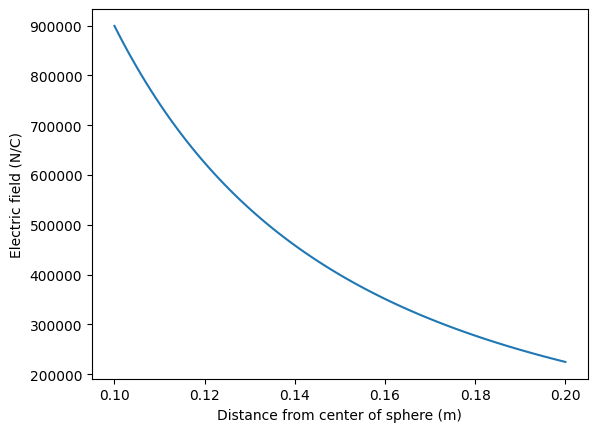

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
epsilon_0 = 8.85e-12   # vacuum permittivity
Q = 1e-6               # charge on sphere
a = 0.1                # radius of sphere

# Define the distance from the center of the sphere
r = np.linspace(a, 2*a, 100)

# Calculate the electric field using the Coulomb's law
E = Q / (4 * np.pi * epsilon_0 * r**2)

# Plot the electric field as a function of distance from the center of the sphere
plt.plot(r, E)
plt.xlabel('Distance from center of sphere (m)')
plt.ylabel('Electric field (N/C)')
plt.show()


In [30]:
import numpy as np

# Define a point in space where we want to calculate the electric field direction
r_point = np.array([1, 2, 3])  # x, y, z coordinates

# Define the center of the sphere
r_center = np.array([0, 0, 0])  # x, y, z coordinates

# Calculate the direction of the electric field vector
e_field_dir = (r_point - r_center) / np.linalg.norm(r_point - r_center)

print("Electric field direction:", e_field_dir)


Electric field direction: [0.26726124 0.53452248 0.80178373]


In [31]:
import numpy as np

# Define the electric field vector and its magnitude
E_mag = 1e-6  # N/C
E_dir = np.array([1, 0, 0])  # x, y, z components

# Define the dipole moment vector and its magnitude
q = 1e-9  # C
d = 1e-6  # m
p = 2 * q * d * np.array([1, 0, 0])  # dipole moment vector

# Define the moment of inertia of the dipole
I = 1/12 * (2*q*d)**2  # assuming two point charges

# Calculate the torque on the dipole
tau = np.cross(p, E_mag * E_dir)

# Calculate the angular acceleration of the dipole
alpha = tau / I

# Integrate the angular acceleration twice to obtain the position of the dipole
t = np.linspace(0, 1, 100)  # time array
theta_0 = 0  # initial angle
omega_0 = 0  # initial angular velocity

theta = theta_0 + omega_0 * t + 1/2 * alpha[0] * t**2
x = d * np.cos(theta)
y = d * np.sin(theta)
z = np.zeros_like(x)

# Print the position of the dipole at the final time
print("Final position of the dipole:", x[-1], y[-1], z[-1])


Final position of the dipole: 1e-06 0.0 0.0


### How do I represent in python a radial electric field generated by a sphere?

To represent the radial electric field generated by a sphere in Python, you can use the following code:

```python
import numpy as np
import matplotlib.pyplot as plt

# Define constants
epsilon_0 = 8.85e-12   # vacuum permittivity
Q = 1e-6               # charge on sphere
a = 0.1                # radius of sphere

# Define the distance from the center of the sphere
r = np.linspace(a, 2*a, 100)

# Calculate the electric field using the Coulomb's law
E = Q / (4 * np.pi * epsilon_0 * r**2)

# Plot the electric field as a function of distance from the center of the sphere
plt.plot(r, E)
plt.xlabel('Distance from center of sphere (m)')
plt.ylabel('Electric field (N/C)')
plt.show()
```

In this code, we first import the necessary libraries, numpy and matplotlib. Then we define the constants, including the vacuum permittivity, the charge on the sphere, and the radius of the sphere. Next, we define an array of distances from the center of the sphere using np.linspace(). We then calculate the electric field at each distance using Coulomb's law, and plot the resulting electric field as a function of distance using plt.plot(). Finally, we add axis labels and display the plot using plt.show().



### How can I calculate the direction of said electric field?

The electric field generated by a positively charged sphere is radial, which means it points outward in all directions away from the center of the sphere.

In Python, you can calculate the direction of the electric field vector using vector algebra. For example, you can define a vector in the direction of the radial electric field as:

```python
import numpy as np

# Define a point in space where we want to calculate the electric field direction
r_point = np.array([1, 2, 3])  # x, y, z coordinates

# Define the center of the sphere
r_center = np.array([0, 0, 0])  # x, y, z coordinates

# Calculate the direction of the electric field vector
e_field_dir = (r_point - r_center) / np.linalg.norm(r_point - r_center)

print("Electric field direction:", e_field_dir)
```

In this code, we define a point in space r_point where we want to calculate the direction of the electric field. We also define the center of the sphere r_center. We then calculate the vector pointing from the center of the sphere to the point in space using r_point - r_center, and divide it by its magnitude to obtain a unit vector pointing in the direction of the electric field. Finally, we print the electric field direction using print().



### Given the value of the electric field and its direction in some point, how can I calculate the traslation of an electric dipole that it is located in that point?

To calculate the translation of an electric dipole located at a given point in the presence of an electric field with a known magnitude and direction, you can use the following steps:

1. Calculate the electric dipole moment vector. The electric dipole moment is given by the product of the magnitude of the charge on the dipole and the distance between the charges, multiplied by a unit vector in the direction from the negative to the positive charge. If the charges have equal magnitude and opposite sign, the dipole moment is simply twice the magnitude of one of the charges times the distance between them, multiplied by the unit vector.

2. Calculate the torque acting on the dipole. The torque is given by the cross product of the dipole moment vector and the electric field vector.

3. Calculate the angular acceleration of the dipole. The angular acceleration is given by the torque divided by the moment of inertia of the dipole.

4. Integrate the angular acceleration twice to obtain the position of the dipole as a function of time.

Here is an example Python code that implements these steps:

```python
import numpy as np

# Define the electric field vector and its magnitude
E_mag = 1e-6  # N/C
E_dir = np.array([1, 0, 0])  # x, y, z components

# Define the dipole moment vector and its magnitude
q = 1e-9  # C
d = 1e-6  # m
p = 2 * q * d * np.array([1, 0, 0])  # dipole moment vector

# Define the moment of inertia of the dipole
I = 1/12 * (2*q*d)**2  # assuming two point charges

# Calculate the torque on the dipole
tau = np.cross(p, E_mag * E_dir)

# Calculate the angular acceleration of the dipole
alpha = tau / I

# Integrate the angular acceleration twice to obtain the position of the dipole
t = np.linspace(0, 1, 100)  # time array
theta_0 = 0  # initial angle
omega_0 = 0  # initial angular velocity

theta = theta_0 + omega_0 * t + 1/2 * alpha[0] * t**2
x = d * np.cos(theta)
y = d * np.sin(theta)
z = np.zeros_like(x)

# Print the position of the dipole at the final time
print("Final position of the dipole:", x[-1], y[-1], z[-1])
```

In this code, we first define the electric field vector and its magnitude, and the dipole moment vector and its magnitude. We also calculate the moment of inertia of the dipole assuming two point charges. We then calculate the torque acting on the dipole, and the angular acceleration of the dipole. We integrate the angular acceleration twice using the initial conditions of the dipole (initial angle and angular velocity both equal to zero) and a time array, to obtain the position of the dipole as a function of time. Finally, we print the final position of the dipole at the end of the time array. Note that this is a simple example and assumes a dipole of fixed orientation, so the translation of the dipole will depend on the orientation of the dipole relative to the electric field.